Simply debug the adaptative gridding code : run it for a range of tau, sigma profiles ...

In [2]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_dr7_quasar
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [6]:
import modules as mod

In [10]:

SF_inf = 0.2 # mag 
t_exp = 8 * 365.0 # in days  # the length of the light curve 

t445 = np.sort(np.random.randint(low=0, high=t_exp, size=445))

plot = False

ogle_lc = {}
t = t445

# iterate over rho grid , which is the grid of 
# input values of tau 
rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)
for i,rho_in in enumerate(rho_grid) : 
    tau_in = rho_in * t_exp
    ogle_lc[i] = {'rho':rho_in,
                  'y': mod.sim_DRW_lightcurve(t, SF_inf, tau_in , 18)}


In [44]:
# functions for adaptative gridding .... 
def calculate_log_posterior(prior, params,y,gp):
    if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
        def neg_log_like(params,y,gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
            # - log_likelihood - log(prior)
            log_prior = - (log_a / 2.0) + log_c
            return -gp.log_likelihood(y, quiet=True) - log_prior
    
    if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
             # - log_likelihood - log(prior)
            log_prior  = 0.5* (-np.log(2.0) - log_a + log_c  )
            return -gp.log_likelihood(y, quiet=True)  - log_prior
        
    return -neg_log_like(params, y, gp)

# Gaussian noise added to each light curve
loc=0; var = 0.0248445133097
noise  = np.random.normal(loc=loc,scale=np.sqrt(var),size=445)

# Variance for OGLE - using eq. from Kozlowski+2017
I = 18 # mag  - mean magnitude of the assumed light curve 
variance = 0.004**2.0 + np.exp(1.63 * (I - 22.55)) 

# All input params to # initialize Celerite DRW kernel 


for i in range(50,51):# len(ogle_lc.keys())): 
    print(i)
    rho_in = ogle_lc[i]['rho']
    tau_in = rho_in * t_exp
    yDRW = ogle_lc[i]['y']
    
    # make a random draw from a Gaussian distribution centered on 0,
    # with variance set by the equation from Kozlowski+2017
    noise = np.random.normal(loc=0,scale=np.sqrt(variance),size=len(yDRW))
    
    y_obs = yDRW + noise 
    # the uncertainty on each measurement : 
    # I set it to sigma_SDSS = 0.0248, or sigma_OGLE = 0.0131,
    # homoscedastic, i.e. same errors for all points 
    yerr = np.ones_like(t)* np.sqrt(variance)
    
    # define which priors we would like to try ... 
    #priors = ['Jeff1','Jeff2'] 
    
     # call the model  with a chosen kernel instance 
    gp = celerite.GP(kernel, mean=np.mean(y_obs))
    gp.compute(t, yerr)

    # set initial params 
    initial_params = gp.get_parameter_vector()

    # set boundaries for Celerite 
    sig_lims = [0.02, 0.7]  ; tau_lims = [1,10000]
    tau_bounds, sigma_bounds = tau_lims, sig_lims
    logc_bounds= (-np.log(max(tau_bounds)), 
                  -np.log(min(tau_bounds))
                 )
    loga_bounds = (2*np.log(min(sigma_bounds)), 
                   2*np.log(max(sigma_bounds)))
    bounds = [loga_bounds, logc_bounds]

    print('tau_in = ', tau_in)
    #results = {}
    #for prior in priors: 
    #prior = 'Jeff1'
    #results[prior] = {}
    # starting grid : for each LC we need to start it anew...
    N = 60 
    sig_lims = [0.02, 0.7] ; tau_lims = [1,1000]
    sigma_grid = np.linspace(sig_lims[0], sig_lims[1],N )
    tau_grid  = np.linspace(tau_lims[0], tau_lims[1], N)
    log_a_grid = 2 * np.log(sigma_grid)
    log_c_grid = np.log(1/tau_grid)

    def neg_log_like(params,y,gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y, quiet=True) 

    # loop over the likelihood space .... 
    logPosterior = np.zeros([N,N], dtype=float)
    for k in range(len(log_a_grid)):
        for l in range(len(log_c_grid)):
            params = [log_a_grid[k],log_c_grid[l]]    
            logPosterior[k,l] = neg_log_like(params,y_obs,gp)
            
    if np.sum(np.isinf(logPosterior)) > 0.9 * len(np.ravel(logPosterior)):
        print('cannot do adaptative grid, over 90 percent is infinite')

50
tau_in =  375.422114081
cannot do adaptative grid, over 90 percent is infinite


In [92]:
yerr

array([ 0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02484451,
        0.02484451,  0.02484451,  0.02484451,  0.02484451,  0.02

### Working example ( for tuning and checking for failure modes)

[-3.21887582 -4.60517019]
[(-7.8240460108562919, -0.71334988787746489), (-5.0106352940962555, 0.0)]
tau_fit 150.0
sigma_fit 0.188198660469


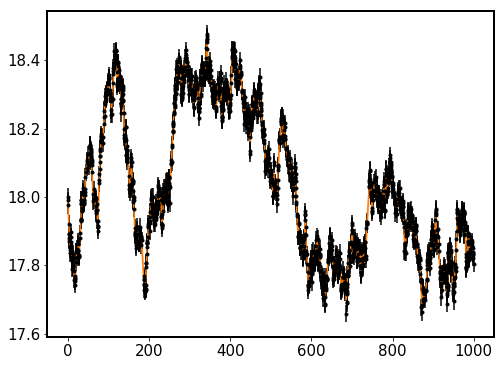

In [155]:
sigma_in = 0.2
tau_in = 100
SF_inf =  sigma_in * np.sqrt(2)

kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1.0/tau_in))

t = np.sort(np.random.uniform(0,1000, 2000)) 
y = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , 18)

I = 18
#variance = 0.004**2.0 + np.exp(1.63 * (I - 22.55))  
yerr = 0.0248 #np.ones_like(t)* np.sqrt(variance)

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

# set initial params 
initial_params = gp.get_parameter_vector()
print(initial_params)
#bounds = gp.get_parameter_bounds()

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

set_bounds = True 
if set_bounds:
    sig_lims = [0.02, 0.7]  ; tau_lims = [1,150]
    tau_bounds, sigma_bounds = tau_lims, sig_lims
    loga_bounds = (2*np.log(min(sigma_bounds)), 
                   2*np.log(max(sigma_bounds)))

    logc_bounds= (np.log(1/max(tau_bounds)), 
                  np.log(1/ min(tau_bounds))         )

    bounds = [loga_bounds, logc_bounds]

else : # - inf to + inf 
    bounds = gp.get_parameter_bounds()
print(bounds)

r = minimize(neg_log_like, initial_params, 
         method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
#print(r)
res = gp.get_parameter_dict()

tau_fit = np.exp(-res['kernel:log_c'])
sigma_fit = np.exp(res['kernel:log_a']/2)
print('tau_fit', tau_fit)
print('sigma_fit', sigma_fit )

x = np.linspace(min(t), max(t), 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, 
                 color=color, alpha=0.3,
                 )

In [138]:
pred_mean

array([ 18.00600839,  18.00713034,  18.00870153, ...,  18.06114955,
        18.06396778,  18.06581509])

In [90]:
max(t)

2916

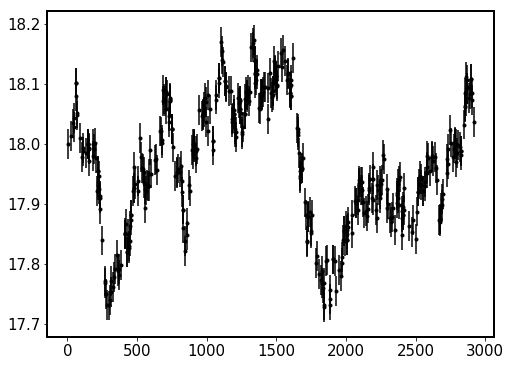

Initial log likelihood: -6.756596382629269
      fun: -16.56320171269553
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.84217094e-06,   1.05160325e-04,  -4.54747351e-05,
        -5.68434189e-06,  -5.20117283e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 252
      nit: 30
   status: 0
  success: True
        x: array([ 3.277941  , -2.02450473, -4.16135883,  2.34185049,  1.13554439])


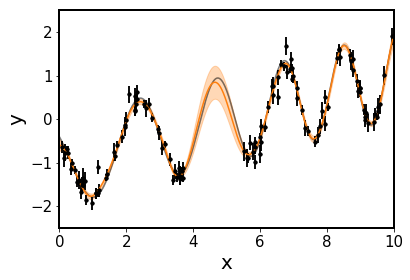

In [61]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)


gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

gp.get_parameter_dict()

x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [60]:
gp.predict?

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


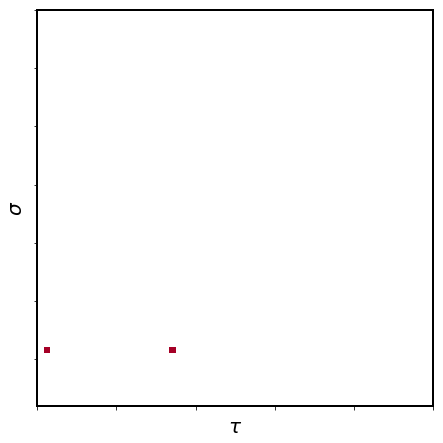

In [37]:
x = -logPosterior
shift = x-min(np.ravel(x))
norm = np.sum(shift)
z = shift / norm

fig = plt.figure(figsize=(10, 10))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.imshow(z, extent=(tau_grid[0], tau_grid[-1], 
                      sigma_grid[0], sigma_grid[-1]),
         cmap=plt.cm.get_cmap('RdYlBu'),vmax=1e-4,
        aspect='auto', origin='lower')
ax1.set_ylabel(r'$\sigma$')
ax1.set_xlabel(r'$\tau$')



In [3]:

# the core of the adaptative grid code 
def find_new_limits(grid, logP, param = 'sigma', threshold=0.1 ,
                    verbose=True):
    dx = grid[1] - grid[0]
    if param is 'tau':
        p_x = np.exp(logP).sum(0)
    if param is 'sigma':
        p_x = np.exp(logP).sum(1)
    p_x /= p_x.sum() * (dx)  # this ensures probability adds up to 1 
    p_x /= max(p_x)  # this ensures that max prob is 1 

    min_idx = np.where(p_x > threshold)[0][0]  
    max_idx = np.where(p_x > threshold)[0][-1]
    print(min_idx, max_idx, grid[min_idx], grid[max_idx])
    
    # case where the beginning of grid is the beginning of peak.... 
    if max_idx == 0 : 
        if param is 'tau':
            new_min = 1 
            new_max = 0.2 * grid[1]
            
        if param is 'sigma':
            new_min = 0.1 * min(grid)
            new_max = grid[1]
            
        if verbose:
            print('max_idx = 0')

    # case where the peak is really close to the  
    # initial beginning of the grid ... 
    # need to lower the grid limit below the initial value ... 
    elif ( (min_idx >= 0) * (min_idx < 5) * ((max_idx) <= len(grid)) ): 
        new_min = 0.5 * min(grid)
        new_max = grid[max_idx]
        if verbose:
            print('peak very close to the grid minimum')

    # case where the peak is well contained within
    # the actual grid
    elif (min_idx >= 5) * ((max_idx+5) <= len(grid)):
        new_min = grid[min_idx-2]
        new_max = grid[max_idx+2]
        if verbose:
            print('peak contained in the grid ')

    # case where the beginning is well contained, 
    # and the end is less than 5 units away
    # from the edge 
    elif (min_idx >= 5) *((min_idx +5)<= len(grid)) * ((max_idx+5) > len(grid)):
        new_min = grid[min_idx-2]
        new_max = grid[max_idx]
        if verbose:
            print('peak end close to the edge of the  grid ')
    # case where the beginnig of the peak 
    # is close to the end of the grid 
    # we need to move the minimum closer to the end 
    # and extend the maximum...
    elif (min_idx + 5) > len(grid) : 
        new_min = grid[min_idx-2]
        new_max = 1.5 * max(grid)
        if verbose:
            print('peak close to the grid maximum ')
            

    new_limits = [new_min, new_max]
    
    print('New ',param,' limits are: ', new_limits)
    
    return new_limits



In [ ]:
sigma_grid = np.linspace(sig_lims[0], sig_lims[1],N )
tau_grid  = np.linspace(tau_lims[0], tau_lims[1], N)
log_a_grid = 2 * np.log(sigma_grid)
log_c_grid = np.log(1/tau_grid)

# loop over the likelihood space .... 
logPosterior = np.zeros([N,N], dtype=float)
for k in range(len(log_a_grid)):
    for l in range(len(log_c_grid)):
        params = [log_a_grid[k],log_c_grid[l]]    
        logPosterior[k,l] = calculate_log_posterior(prior, params,y,gp)
                
find_new_limits(grid, logP, param = 'sigma', threshold=0.1 ,
                    verbose=True):